# Classify the tiles using pretrained tile2vec
In this notebook we are going to measure the performance of classifier on EuroSATallbands dataset.

We will use model weights that are in the `/storage/tile2vec/models/`. Firstly we need to load the weights and create the embeddings of the tiles using our pretrained model.

## Load tile2vec model

In [2]:
import os
import torch
from pathlib import Path

import sys
sys.path.append('..')

from src.tilenet import make_tilenet

model_dir = Path('/storage/tile2vec/models')
# model_fn = model_dir / model_filepath # specify which model weights are to be loaded
bands = 13 # number of bands in the input data - should matche the model
z_dim = 512 # output dimension of the last layer of the encoder - should match the model
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
cuda = torch.cuda.is_available()

In [3]:
def load_model(model_filepath):
    model_dir = Path('/storage/tile2vec/models')
    model_fn = model_dir / model_filepath # specify which model weights are to be loaded
    bands = 13 # number of bands in the input data - should matche the model
    z_dim = 512 # output dimension of the last layer of the encoder - should match the model


    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    cuda = torch.cuda.is_available()


    tilenet = make_tilenet(in_channels=bands, z_dim=z_dim) 
    if cuda: 
        tilenet.cuda()

    checkpoint = torch.load(model_fn)
    tilenet.load_state_dict(checkpoint)
    tilenet.eval()
    return tilenet

## load the bare files and organize them into a dataframe



In [4]:
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
from pathlib import Path
from src.data_utils import clip_and_scale_image

In [5]:
val_df = pd.read_csv("/storage/EuroSATallBands/validation.csv")
n_tiles = len(val_df)
tiles_path = Path("/storage/tile2vec/npy/val")

X_bare_val = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)
X_norm_val = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)

for index in tqdm(range(n_tiles)):
    tile = np.load(tiles_path / f"{index}.npy")
    X_norm_val[index] = clip_and_scale_image(tile, img_type="sentinel").flatten()
    X_bare_val[index] = tile.flatten()
    
y_val = val_df["Label"]

test_df = pd.read_csv("/storage/EuroSATallBands/test.csv")
n_tiles = len(test_df)
tiles_path = Path("/storage/tile2vec/npy/test")

X_bare_test = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)
X_norm_test = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)

for index in tqdm(range(n_tiles)):
    tile = np.load(tiles_path / f"{index}.npy")
    X_norm_test[index] = clip_and_scale_image(tile, img_type="sentinel").flatten()
    X_bare_test[index] = tile.flatten()
    
y_test = test_df["Label"]


train_df = pd.read_csv("/storage/EuroSATallBands/train.csv")
n_tiles = len(train_df)
tiles_path = Path("/storage/tile2vec/npy/train")

X_bare_train = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)
X_norm_train = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)

for index in tqdm(range(n_tiles)):
    tile = np.load(tiles_path / f"{index}.npy")
    X_norm_train[index] =  clip_and_scale_image(tile, img_type="sentinel").flatten()

    X_bare_train[index] = tile.flatten()
    
y_train = train_df["Label"]

  0%|          | 0/5519 [00:00<?, ?it/s]

100%|██████████| 19317/19317 [00:10<00:00, 1851.15it/s]


## create embeddings
Our dataset is already divided into parts - train, validation and test. Therefore we will use the split to train our classifier. We will train the classifier on the validation dataset using crossvalidation. Later, we will measure its performance on the test set to make its behaviour comparable

In [6]:
def create_embeddings_tile2vec(tilenet, df_filepath: str | Path, tiles_path: str | Path, img_type: str = "sentinel"):
    """
    function creates matrix X and y containing embeddings and labels, loads the tiles from directory `tiles_path`
    """
    df_filepath = Path(df_filepath)
    tiles_path = Path(tiles_path)
    df = pd.read_csv(df_filepath)
    n_tiles = len(df)    
    
    X = np.zeros((n_tiles, z_dim))
    
    t0 = time()
    # this solution to iterate over examples is very suboptimal, one should use torch dataset
    for index in tqdm(range(n_tiles)):
        # read the tile from provided filepath
        
        tile = np.load(tiles_path / f"{index}.npy")  
        tile = clip_and_scale_image(tile, img_type=img_type)
        tile = torch.from_numpy(tile).float()
        tile = (tile)
        if cuda: 
            tile = tile.cuda()
        z = tilenet.encode(tile)
        if cuda: 
            z = z.cpu()
        z = z.data.numpy()
        
        X[index,:] = z

    t1 = time()
    print('Embedded {} tiles: {:0.3f}s'.format(n_tiles, t1-t0))
    
    y = df['Label'].values
    
    return X, y   

# Set up models

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

rf = RandomForestClassifier()
lr = LogisticRegression()



## function for vizualization

In [12]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import json

def vizualize_tsne_2d(X:np.ndarray, y:np.ndarray, text = "", **kwargs) -> None:
    # create tsne
    tsne = TSNE(n_components=2, **kwargs)
    tsne_result = tsne.fit_transform(X)

    tsne_result = pd.DataFrame(tsne_result)
    tsne_result

    # create dataframe to plot
    plot_data = pd.concat([pd.DataFrame(tsne_result), pd.DataFrame(y, columns=['label'])], axis = 1)

    # change numbers to meaningful text labels
    with open('/storage/EuroSATallBands/label_map.json') as f:
        label_map = json.load(f)
    reverse_label_map = {v:k for k, v in label_map.items()}
    reverse_label_map

    y_valtest_text = pd.Series(y).map(reverse_label_map)

    # plot tsne
    fig,ax = plt.subplots()
    for label in np.unique(plot_data['label']).tolist():
        x_plot,y_plot,lab = (plot_data.loc[plot_data['label']==label,0],plot_data.loc[plot_data['label']==label,1],plot_data.loc[plot_data['label']==label,'label'])
        ax.scatter(x_plot, y_plot, label = lab)
    ax.set_title(f"TSNE on tile2vec ({text})")
    ax.legend(np.unique(y_valtest_text), title = "Labels", bbox_to_anchor = (1.1,1.05))


def vizualize_tsne_3d(X:np.ndarray, y:np.ndarray, text = "") -> None:
    # create tsne
    tsne = TSNE(n_components=3)
    tsne_result = tsne.fit_transform(X)
    tsne_result = pd.DataFrame(tsne_result)

    # create dataframe to plot
    plot_data = pd.concat([pd.DataFrame(tsne_result), pd.DataFrame(y, columns=['label'])], axis = 1)

    # change numbers to meaningful text labels
    with open('/storage/EuroSATallBands/label_map.json') as f:
        label_map = json.load(f)
    reverse_label_map = {v:k for k, v in label_map.items()}
    reverse_label_map

    y_valtest_text = pd.Series(y).map(reverse_label_map)

    # plot tsne
    fig = plt.figure()
    ax = fig.add_subplot(projection = "3d")
    for label in np.unique(plot_data['label']).tolist():
        x_plot,y_plot,z_plot,lab = (plot_data.loc[plot_data['label']==label,0],
                    plot_data.loc[plot_data['label']==label,1],
                    plot_data.loc[plot_data['label']==label,2],
                    plot_data.loc[plot_data['label']==label,'label'])
        ax.scatter(x_plot, y_plot, z_plot, label = lab)
    ax.set_title(f"TSNE on tile2vec ({text})")
    ax.legend(np.unique(y_valtest_text), title = "Labels", bbox_to_anchor = (1.1,1.05))


# No band normalization
Here we are going to check the performance of model with no band normalization

In [33]:
no_normalization = load_model("TileNet_simple.ckpt")
X_validation, y_validation = create_embeddings_tile2vec(no_normalization, '/storage/EuroSATallBands/validation.csv', '/storage/tile2vec/tif/val', "landsat")
X_test, y_test = create_embeddings_tile2vec(no_normalization, '/storage/EuroSATallBands/test.csv', '/storage/tile2vec/tif/test', "landsat")
X = np.concatenate((X_validation, X_test), axis=0)  
y = np.concatenate((y_validation, y_test), axis=0)

100%|██████████| 5519/5519 [00:18<00:00, 297.81it/s]


Embedded 5519 tiles: 18.535s


100%|██████████| 2759/2759 [00:08<00:00, 310.82it/s]

Embedded 2759 tiles: 8.879s


In [ ]:
# TODO viz?

# Contrastive loss - default with no modifications


In [9]:
custom_clipping = load_model("TileNet_no_triplets_simple.ckpt")
X_validation, y_validation = create_embeddings_tile2vec(custom_clipping, '/storage/EuroSATallBands/validation.csv', '/storage/tile2vec/tif/val')
X_test, y_test = create_embeddings_tile2vec(custom_clipping, '/storage/EuroSATallBands/test.csv', '/storage/tile2vec/tif/test')

X = np.concatenate((X_validation, X_test), axis=0)
y = np.concatenate((y_validation, y_test), axis=0)

# compare_results(X, y, rf, folds = 5)
# compare_results(X, y, lr, folds = 5)

100%|██████████| 5519/5519 [00:23<00:00, 239.47it/s]


Embedded 5519 tiles: 23.049s


100%|██████████| 2759/2759 [00:10<00:00, 257.16it/s]

Embedded 2759 tiles: 10.730s


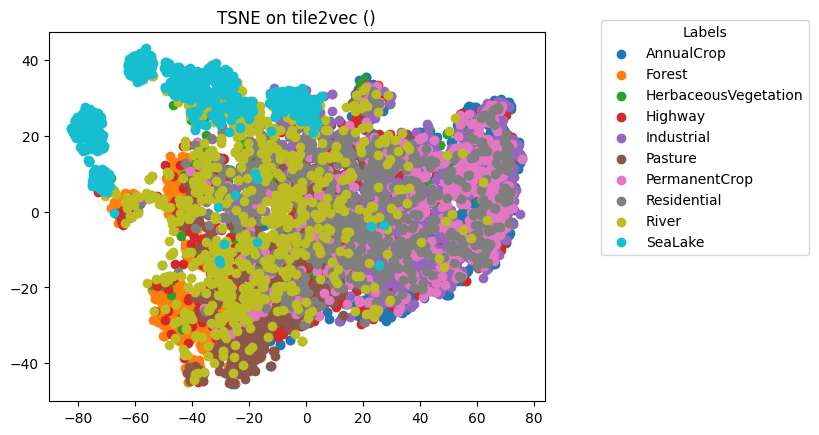

In [19]:
vizualize_tsne_2d(X,y, random_state=2137, perplexity=50)

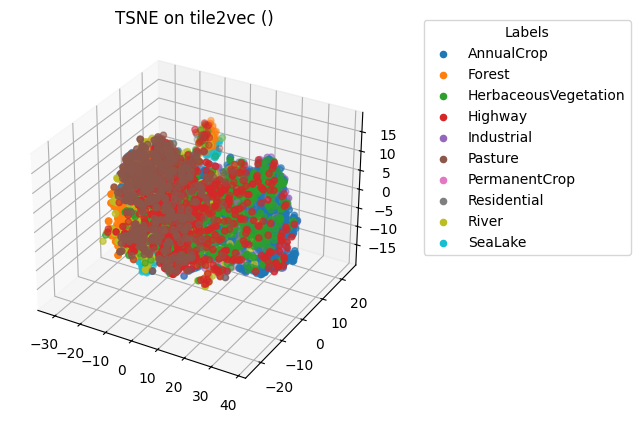

In [11]:
vizualize_tsne_3d(X,y)